  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


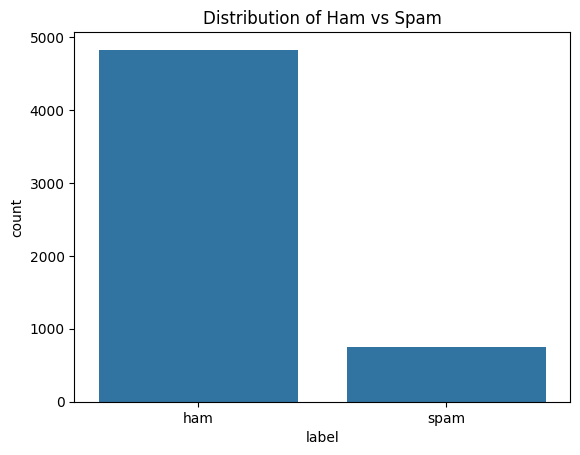

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("/content/SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])

print(df.head())

# Class distribution drawing
sns.countplot(x='label', data=df)
plt.title("Distribution of Ham vs Spam")
plt.show()


Preparing spam category data only

In [ ]:
# Preparing spam category data only
# Filter spam data only
spam_df = df[df['label'] == 'spam']

# View sample
spam_df.head()


,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


represent texts as vectors so that we can train the GAN on them

In [ ]:
# represent texts as vectors so that we can train the GAN on them
from sklearn.feature_extraction.text import TfidfVectorizer

# Converting Text to Vectors Using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # نستخدم عدد محدود من الكلمات لأبسط نموذج
spam_vectors = vectorizer.fit_transform(spam_df['text']).toarray()

# The format of the resulting data
print(spam_vectors.shape)


(747, 100)


Vanilla GAN

In [ ]:
# Vanilla GAN
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

latent_dim = 50  # The amount of noise entering the generator
input_dim = spam_vectors.shape[1]

# generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(input_dim, activation='sigmoid')
    ])
    return model

# discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dense(1, activation='sigmoid')  #Distinguish between real and fake
    ])
    return model


Vanilla GAN Training

In [ ]:
# Vanilla GAN Training
import tensorflow as tf
import numpy as np

batch_size = 32
epochs = 1000
latent_dim = 50

# Building models
generator = build_generator()
discriminator = build_discriminator()


loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

# Convert data to tensor
spam_tensor = tf.convert_to_tensor(spam_vectors, dtype=tf.float32)

# Training
for epoch in range(epochs):
    # Real sample data
    idx = np.random.randint(0, spam_vectors.shape[0], batch_size)
    real_samples = tf.gather(spam_tensor, tf.convert_to_tensor(idx, dtype=tf.int32))


    # Random sample of noise
    noise = tf.random.normal([batch_size, latent_dim])

    # Fake generator samples
    fake_samples = generator(noise)

    #  Distinguished Training
    with tf.GradientTape() as tape:
        real_output = discriminator(real_samples)
        fake_output = discriminator(fake_samples)
        disc_loss = loss_fn(tf.ones_like(real_output), real_output) + \
                    loss_fn(tf.zeros_like(fake_output), fake_output)

    grads = tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    #  Generator training
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as tape:
        generated = generator(noise)
        output = discriminator(generated)
        gen_loss = loss_fn(tf.ones_like(output), output)

    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Every 100 Epochs we print the loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D_loss = {disc_loss:.4f}, G_loss = {gen_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0: D_loss = 1.5082, G_loss = 0.6060
Epoch 100: D_loss = 0.7859, G_loss = 2.0979
Epoch 200: D_loss = 0.7404, G_loss = 2.4343
Epoch 300: D_loss = 0.6222, G_loss = 2.3475
Epoch 400: D_loss = 0.5265, G_loss = 2.0672
Epoch 500: D_loss = 0.6028, G_loss = 1.6324
Epoch 600: D_loss = 0.8330, G_loss = 1.1174
Epoch 700: D_loss = 1.1785, G_loss = 0.8246
Epoch 800: D_loss = 1.4391, G_loss = 0.6465
Epoch 900: D_loss = 1.4483, G_loss = 0.5910


In [ ]:
# Generate 5 fake samples
noise = tf.random.normal([5, latent_dim])
generated_samples = generator(noise).numpy()


features = np.array(vectorizer.get_feature_names_out())
for i, vec in enumerate(generated_samples):
    top_indices = vec.argsort()[-10:][::-1]
    print(f"\n spam {i+1}:")
    print(" ".join(features[top_indices]))



 spam 1:
call you mobile ur for is out apply can 16

 spam 2:
you call mobile stop 150p customer is guaranteed to from

 spam 3:
is from txt now prize msg ur per won we

 spam 4:
mobile to stop for call your and now with who

 spam 5:
is or free win uk only out on of can


CGAN

Generator

In [ ]:
# CGAN
# Generator

from tensorflow.keras import layers, models

def build_cgan_generator(latent_dim, output_dim, num_classes):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Convert label to embedding
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    # Merge noise with label
    conditioned_input = layers.Multiply()([noise_input, label_embedding])

    x = layers.Dense(128, activation='relu')(conditioned_input)
    x = layers.Dense(output_dim, activation='sigmoid')(x)

    return models.Model([noise_input, label_input], x)



Discriminator

In [ ]:
# Discriminator
def build_cgan_discriminator(latent_dim, output_dim, num_classes=2):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    conditioned_input = layers.multiply([noise_input, label_embedding])

    x = layers.Dense(128, activation='relu')(conditioned_input)
    x = layers.Dense(1, activation='sigmoid')(x)

    return models.Model([noise_input, label_input], x)



Generator and discriminator setup


In [ ]:
# Generator and discriminator setup
latent_dim = 100
num_classes = 2  # ham = 0, spam = 1

output_dim = spam_vectors.shape[1]  # عدد ميزات TF-IDF
generator_cgan = build_cgan_generator(latent_dim, output_dim, num_classes)
discriminator_cgan = build_cgan_discriminator(output_dim, num_classes)



# Compile discriminator
discriminator_cgan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Freeze discriminator for combined model
discriminator_cgan.trainable = False

# Combined model (Generator + Discriminator)
noise_input = tf.keras.Input(shape=(latent_dim,))
label_input = tf.keras.Input(shape=(1,), dtype='int32')
generated_data = generator_cgan([noise_input, label_input])
validity = discriminator_cgan([generated_data, label_input])
cgan = tf.keras.Model([noise_input, label_input], validity)

cgan.compile(optimizer='adam', loss='binary_crossentropy')


CGAN Training

In [ ]:
# CGAN Training
epochs = 1000
batch_size = 32

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):

    #  Train Discriminator

    idx = np.random.randint(0, spam_vectors.shape[0], batch_size)
    real_samples = tf.gather(spam_tensor, tf.convert_to_tensor(idx, dtype=tf.int32))
    real_class_labels = np.ones((batch_size, 1))  # All spam = 1

    noise = tf.random.normal((batch_size, latent_dim))
    fake_class_labels = np.ones((batch_size, 1))  # same condition (spam)

    generated_samples = generator_cgan.predict([noise, fake_class_labels], verbose=0)

    d_loss_real = discriminator_cgan.train_on_batch([real_samples, real_class_labels], real_labels)
    d_loss_fake = discriminator_cgan.train_on_batch([generated_samples, fake_class_labels], fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    #  Train Generator

    noise = tf.random.normal((batch_size, latent_dim))
    misleading_labels = np.ones((batch_size, 1))  # trick the discriminator

    g_loss = cgan.train_on_batch([noise, fake_class_labels], real_labels)

    # كل 100 دورة نطبع الخسائر
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D_loss = {d_loss[0]:.4f}, D_acc = {d_loss[1]*100:.2f}%, G_loss = {g_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D_loss = 0.6940, D_acc = 14.06%, G_loss = 0.6915
Epoch 100: D_loss = 0.7015, D_acc = 14.75%, G_loss = 0.6772
Epoch 200: D_loss = 0.7082, D_acc = 14.45%, G_loss = 0.6645
Epoch 300: D_loss = 0.7109, D_acc = 14.13%, G_loss = 0.6596
Epoch 400: D_loss = 0.7122, D_acc = 13.96%, G_loss = 0.6570
Epoch 500: D_loss = 0.7131, D_acc = 13.92%, G_loss = 0.6555
Epoch 600: D_loss = 0.7136, D_acc = 13.83%, G_loss = 0.6545
Epoch 700: D_loss = 0.7140, D_acc = 13.79%, G_loss = 0.6537
Epoch 800: D_loss = 0.7143, D_acc = 13.80%, G_loss = 0.6531
Epoch 900: D_loss = 0.7146, D_acc = 13.81%, G_loss = 0.6527


Generate text samples

In [ ]:
# Generate text samples
# Generating 5 fake samples using CGAN
noise = tf.random.normal([5, latent_dim])
labels = np.ones((5, 1))  # فئة spam

generated_samples = generator_cgan.predict([noise, labels], verbose=0)
features = np.array(vectorizer.get_feature_names_out())

for i, vec in enumerate(generated_samples):
    top_indices = vec.argsort()[-10:][::-1]
    print(f"\n spam #{i+1}:")
    print(" ".join(features[top_indices]))




 spam #1:
are have latest reply line is can go get week

 spam #2:
have now week go are it reply line if latest

 spam #3:
have is contact chat in line on stop are now

 spam #4:
is have can now line co week go holiday po

 spam #5:
now line holiday wk get contact have po call are


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model evaluation function
def evaluate_classifier(X, y, name=""):
    # Data partitioning
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model Training (MLP)
    clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=100, random_state=42)
    clf.fit(X_train, y_train)

    # prediction
    y_pred = clf.predict(X_test)

    # Calculate the scales
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {name} ")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return {
        "Dataset": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }


Original imbalanced dataset

In [ ]:
# Original imbalanced dataset
# Convert the original data to x (features) and y (labels)
X_original = df['text']
y_original = df['label'].map({'ham': 0, 'spam': 1})


Dataset balanced using Vanilla GAN

In [ ]:
# Dataset balanced using Vanilla GAN
# Samples were generated using Vanilla GAN previously.
# Convert the generated data to the same structure as the original data.
X_bal_vanilla = generated_samples
y_bal_vanilla = np.ones((generated_samples.shape[0], 1))


Dataset balanced using the GAN variant

In [ ]:
# Dataset balanced using the CGAN
# Samples were generated using CGAN previously.
# Convert the generated data to the same structure as the original data.
X_bal_cgan = generated_samples
y_bal_cgan = np.ones((generated_samples.shape[0], 1))


We need to use TfidfVectorizer to convert text data into numerical representation.

In [ ]:
# We need to use TfidfVectorizer to convert text data into numerical representation.
vectorizer = TfidfVectorizer(max_features=5000)  # Number of features we want to use
X_original_tfidf = vectorizer.fit_transform(X_original).toarray()

In [ ]:
# Applying the function to the three scenarios
results_all = []

results_all.append(evaluate_classifier(X_original_tfidf, y_original, "Original Imbalanced"))
results_all.append(evaluate_classifier(X_bal_vanilla, y_bal_vanilla, "Vanilla GAN Balanced"))
results_all.append(evaluate_classifier(X_bal_cgan, y_bal_cgan, "CGAN Balanced"))


 Original Imbalanced 
Accuracy:  0.9910
Precision: 0.9929
Recall:    0.9396
F1-Score:  0.9655
Confusion Matrix:
[[965   1]
 [  9 140]]

 Vanilla GAN Balanced 
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
Confusion Matrix:
[[1]]

 CGAN Balanced 
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
Confusion Matrix:
[[1]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matr

In [ ]:
results_df = pd.DataFrame(results_all)
results_df.drop(columns=["Confusion Matrix"], inplace=True)
print("\n Summary Table:")
print(results_df.to_string(index=False))


 Summary Table:
             Dataset  Accuracy  Precision   Recall  F1-Score
 Original Imbalanced  0.991031   0.992908 0.939597  0.965517
Vanilla GAN Balanced  1.000000   1.000000 1.000000  1.000000
       CGAN Balanced  1.000000   1.000000 1.000000  1.000000


Confusion Matrix drawing for each case

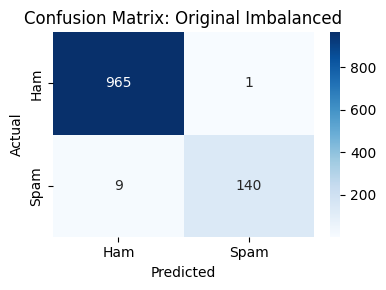

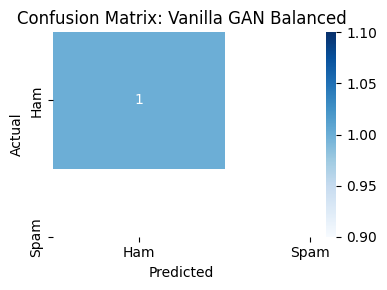

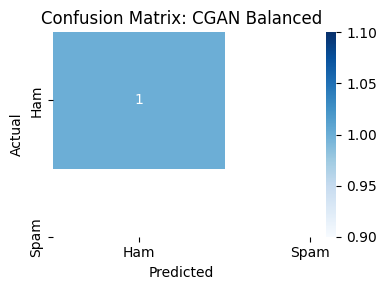

In [ ]:
# Confusion Matrix drawing for each case
for res in results_all:
    cm = res["Confusion Matrix"]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.title(f"Confusion Matrix: {res['Dataset']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    print(" ")
    plt.tight_layout()
    plt.show()